In [1]:
import pytorch_lightning as pl
from matplotlib import pyplot as plt
import seaborn as sns
from cca_zoo.deepmodels import (
    DCCA,
    DCCA_NOI,
    DCCA_SDL,
    BarlowTwins,
    get_dataloaders,
    
)
from cca_zoo.deepmodels.utils import architectures, objectives
from cca_zoo.plotting import pairplot_label
from cca_zoo.data import CCA_Dataset
from cca_zoo.models import CCA
import torch.optim as optim
from sklearn.model_selection import train_test_split
import os
from scipy.spatial import distance
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
import pickle


os.chdir('../raw_data')


In [2]:
os.listdir()

['ALL_GNPS.json',
 'ALL_GNPS_15_12_2021_positive_annotated.pickle',
 'ALL_GNPS_15_12_2021_positive_annotated_classifications.txt',
 'all_ms2ds_embedding.pickle',
 'all_spec_embedding.pickle',
 'data.json',
 'df_ALL_GNPS_15_12_2021_positive_annotated_embeddings_class.pickle',
 'df_classes_all_embeddings.pickle',
 'df_classes_max3_embeddings.pickle',
 'df_classes_max5_embeddings.pickle',
 'df_classes_unique_embeddings.pickle',
 'GNPS_15_12_2021_ms2ds_embeddings.pickle',
 'GNPS_spectra_toconfirm',
 'lightning_logs',
 'max3_mol2vec_embedding.pickle',
 'max3_ms2ds_embedding.pickle',
 'max3_spec_embedding.pickle',
 'max5_mol2vec_embedding.pickle',
 'max5_ms2ds_embedding.pickle',
 'max5_spec_embedding.pickle',
 'model_300dim.pkl',
 'mol2vec_embedding.pickle',
 'ms2ds_embeddings_unique_GNPS_15_12_2021.pickle',
 'ms2ds_model_GNPS_15_12_2021.hdf5',
 'ms2ds_pred_corr',
 'ms2ds_pred_corr_tanimoto',
 'ms2ds_pred_cos.filepart',
 'ms2ds_pred_cos_tanimoto',
 'ms2ds_pred_euc',
 'ms2ds_pred_euc_tanimoto

#### Functions to load and or write to pickle files

In [2]:
class Files:
    def __init__(self, filename):
        self.file = filename
        
    def write_to_file(self, data):
        with open(self.file, 'wb') as f:
            pickle.dump(data, f) 
        return None
    
    def load_pickle(self):
        data = pd.read_pickle(self.file)
        return data
    
    def load_csv(self, sep, usecols=None):
        data = pd.read_csv(self.file, sep=sep, usecols=usecols)
        return data
        
        
    

In [3]:
# load df with all info
path = './df_classes_max3_embeddings.pickle'
df_all = Files(path).load_pickle()#[:20000] #just a subset for scripting
df_all.shape

(41447, 8)

In [6]:
df_all.loc[17213,'spec_id']

'spec_id15508'

In [7]:
# # #drop inchikeys appering once, to make it possible to stratify based on inchikey
# df_all = df_all.groupby('cf_class').filter(lambda x : len(x)>=2)
# df_all.shape

(40095, 8)

In [4]:
#split into train and test dataset
train_df, test_df = \
train_test_split(df_all, test_size=0.3, random_state=42)#, stratify=df_all['cf_class'])

#Split train dataset into train and validation set
test_df, val_df = train_test_split(test_df, test_size=0.1, random_state=42)


#extract the 2 view, v1 == spectra embeddings, v2==structure embeddings
v1_train, v1_test = np.array([x for x in train_df['ms2ds']]), np.array([x for x in test_df['ms2ds']])
v2_train, v2_test = np.array([x for x in train_df['mol2vec']]), np.array([x for x in test_df['mol2vec']])

# validation
v1_val, v2_val = np.array([x for x in val_df['ms2ds']]), np.array([x for x in val_df['mol2vec']])

In [5]:
# What does CCA dataset do????
train_dataset = CCA_Dataset([v1_train, v2_train])
test_dataset = CCA_Dataset([v1_test, v2_test])
val_dataset = CCA_Dataset([v1_val, v2_val])
batch_size = 700
train_loader , val_loader = get_dataloaders(train_dataset, \
                                            val_dataset,batch_size=batch_size,\
                                            num_workers=6,drop_last=False)
test_loader = get_dataloaders(test_dataset,\
                              batch_size=batch_size, \
                              num_workers=6,drop_last=False)

In [6]:



#code is still a mess: STRUCTURE!!!
#params
N = len(train_dataset)
latent_dims = 50
epochs = v2_train.shape[1]
lr = 0.001
#optimizer = optim.SGD(lr=0.01, momentum=0.9)


print('\n','-'*20,'\n Training CCA\n','-'*20)
cca = CCA(latent_dims=latent_dims).fit((v1_train, v2_train))# train cca as well for comparison

# define encoders
encoder_1 = architectures.Encoder(latent_dims=latent_dims, \
                                  feature_size=v1_train.shape[1],\
                                  layer_sizes=(500,300,300))
                                     
encoder_2 = architectures.Encoder(latent_dims=latent_dims, \
                                  feature_size=v2_train.shape[1], \
                                  layer_sizes=(500,300,300))



 -------------------- 
 Training CCA
 --------------------


In [7]:
#extract cca correlation
cca_train_corr = cca.score([v1_train, v2_train])
cca_test_corr = cca.score([v1_test, v2_test])

In [20]:
# generate dcca train projections
train_cca_z1, train_cca_z2 = cca.transform([v1_train, v2_train])
train_df['cca_z1'] = [x for x in train_cca_z1]
train_df['cca_z2'] = [x for x in train_cca_z2]

In [21]:
# generate cca val projections
val_cca_z1, val_cca_z2 = cca.transform([v1_val, v2_val])
val_df['cca_z1'] = [x for x in val_cca_z1]
val_df['cca_z2'] = [x for x in val_cca_z2]

In [9]:
%%time
#  # 1. DCCA
dcca = DCCA(
        latent_dims=latent_dims,
        encoders=[encoder_1, encoder_2],
        objective=objectives.CCA,
        optimizer='sgd',
        lr=lr)

 # Define the trainer
#dcca
trainer_dcca = pl.Trainer(
        max_epochs=epochs, log_every_n_steps=1,\
        callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor="val/objective")])

#train
print('\n','-'*20,'\n Training DCCA\n','-'*20)
trainer_dcca.fit(dcca, train_loader,val_loader)

#score
dcca_train_corr = dcca.score(train_loader)
dcca_test_corr = dcca.score(test_loader)


# generate dcca train projections
train_loader , val_loader = get_dataloaders(train_dataset, 
                                            val_dataset, batch_size=batch_size)

train_z1, train_z2 = dcca.transform(train_loader)
train_df['dcca_z1'] = [x for x in train_z1]
train_df['dcca_z2'] = [x for x in train_z2]

# generate dcca train projections
test_loader = get_dataloaders(train_dataset, batch_size=batch_size)
test_z1, test_z2 = dcca.transform(test_loader)
test_df['dcca_z1'] = [x for x in test_z1]
test_df['dcca_z2'] = [x for x in test_z2]

# generate dcca val projections
val_z1, val_z2 = dcca.transform(val_loader)
val_df['dcca_z1'] = [x for x in val_z1]
val_df['dcca_z2'] = [x for x in val_z2]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | encoders | ModuleList | 762 K 
----------------------------------------
762 K     Trainable params
0         Non-trainable params
762 K     Total params
3.049     Total estimated model params size (MB)



 -------------------- 
 Training DCCA
 --------------------


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

ValueError: Length of values (28700) does not match length of index (29012)

In [10]:

# generate dcca train projections
train_loader , val_loader = get_dataloaders(train_dataset, 
                                            val_dataset)
test_loader = get_dataloaders(train_dataset)
train_z1, train_z2 = dcca.transform(train_loader)
train_df['dcca_z1'] = [x for x in train_z1]
train_df['dcca_z2'] = [x for x in train_z2]

# # generate dcca train projections
# test_z1, test_z2 = dcca.transform(test_loader)
# test_df['dcca_z1'] = [x for x in test_z1]
# test_df['dcca_z2'] = [x for x in test_z2]

# generate dcca val projections
val_z1, val_z2 = dcca.transform(val_loader)
val_df['dcca_z1'] = [x for x in val_z1]
val_df['dcca_z2'] = [x for x in val_z2]

In [273]:
%%time
# 2. SDL
sdl = DCCA_SDL(latent_dims,optimizer='sgd',
                N=N, encoders=[encoder_1, encoder_2],
                lam=0.0001, lr=lr,
                objective=objectives.CCA,) # train size

#train
trainer_sdl = pl.Trainer(
        max_epochs=epochs, log_every_n_steps=1)#,
        
        #callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor="train/sdl")])# early stopage to reduce overfitting

print('\n','-'*20,'\n Training SDL\n','-'*20)
sdl=trainer_sdl.fit(sdl, train_loader,val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | encoders | ModuleList | 762 K 
1 | mse      | MSELoss    | 0     
2 | bns      | ModuleList | 0     
----------------------------------------
762 K     Trainable params
0         Non-trainable params
762 K     Total params
3.049     Total estimated model params size (MB)



 -------------------- 
 Training SDL
 --------------------


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Wall time: 2min 2s


C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [12]:
dcca_train_corr

array([0.94470571, 0.92521336, 0.91234075, 0.88349899, 0.8760801 ,
       0.86969164, 0.86510408, 0.86048519, 0.84776843, 0.8415198 ,
       0.83362291, 0.83060912, 0.81868211, 0.80190971, 0.79811482,
       0.78956376, 0.77583135, 0.77302224, 0.76714317, 0.7652693 ,
       0.75188785, 0.74895418, 0.7406178 , 0.73573622, 0.73002147,
       0.71056875, 0.69902446, 0.69644745, 0.6810775 , 0.67555661,
       0.66494006, 0.6587521 , 0.65263497, 0.6335315 , 0.63235324,
       0.62876547, 0.61542815, 0.59906611, 0.56698529, 0.55621316,
       0.53440469, 0.51099823, 0.50288606, 0.46612393, 0.43827715,
       0.34143918, 0.27076109, 0.21637177, 0.0899186 , 0.00483345])

In [271]:

sdl_train_corr = sdl.score(train_loader)
sdl_train_corr[0:5]

array([0.93913936, 0.90916131, 0.86844097, 0.84684927, 0.82497394])

In [ ]:
#array([0.96825956, 0.95638675, 0.95365948, 0.94538253, 0.94008649])
#array([0.96109012, 0.92829286, 0.91989456, 0.89615484, 0.89071668])

In [272]:
sdl_test_corr = sdl.score(test_loader)
sdl_test_corr[0:5]

array([0.93315397, 0.89833364, 0.86018579, 0.84250586, 0.80810776])

In [105]:
embedding = 'MS2DeepScore'
method = 'ALL_3_hidden'
data = 'max3_stratified'
dims = latent_dims

In [106]:
#sns.color_palette("colorblind")

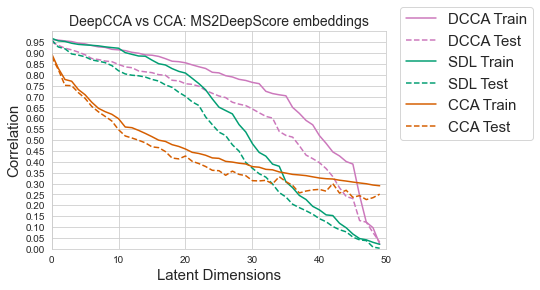

In [107]:
# plot train correlation vs test correlation
x=[x for x in range(latent_dims)]
fig, ax = plt.subplots()

sns.set_style('whitegrid')

line = ['solid', 'dashed']

#justice for the color blind :)
palette = [sns.color_palette("colorblind")[4],\
           sns.color_palette("colorblind")[2],\
           sns.color_palette("colorblind")[3]] 

dfs = [[dcca_train_corr, dcca_test_corr],\
       [sdl_train_corr, sdl_test_corr],\
       [cca_train_corr,cca_test_corr]]

for i, df in enumerate(dfs):
    #train
    sns.lineplot(x=x,y=df[0], \
                 color = palette[i],
                 linestyle=line[0],ax=ax)
    #test
    sns.lineplot(x=x,y=df[1],\
                 color = palette[i],
                 linestyle=line[1], ax=ax)

    plt.legend(labels=['DCCA Train', 'DCCA Test',\
                  'SDL Train', 'SDL Test',\
                  'CCA Train', 'CCA Test'], \
                   loc=(1.04, 0.5),\
                    fontsize=15)#title='Algorithm', 
plt.xlabel('Latent Dimensions', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.ylim(0, 1.0)
plt.title(label=f'DeepCCA vs CCA: {embedding} embeddings',\
          fontsize=14,loc='center')
plt.xlim(0, latent_dims)

plt.yticks(np.arange(0, 1, step=0.05))
plt.savefig(f'../plots/{method}_{data}_{dims}_vs_cca_{embedding}.png',\
           transparent=False,bbox_inches = 'tight')
plt.show()

### Assess Prediction Performance: DCCA

##### Predict Structure from spectra Embeddings

1. Calculate:

    1. Euclidean Distance
    2. Cosine Distance
    3. Correlation

2. Calculate Tanimoto score of top scoring hits based on the above metric

3. Sample a few structures to draw

In [13]:
def predict(subject_df,query_df,\
            method,dims,metric='euc'): #both dfs should have z1 and z2 coloumns

    preds = {}
    
    for query_index, query in enumerate(query_df[f'{method}_z1']): #(query z1)
        
        #query = query_df.loc[query_index,'z1']
        preds[query_index] = []
        for subject in subject_df[f'{method}_z2']:#(subject z2)
        
            #subject = subject_df.loc[subject_index,'z2']
            if metric == 'corr':
                corr = pearsonr(query[:dims], subject[:dims])[0]
                preds[query_index].append(corr)
        
            if metric== 'euc':
                euc = distance.euclidean(query[:dims], subject[:dims])
                preds[query_index].append(euc)
        
            if metric == 'cos':
                cos = distance.cosine(query[:dims], subject[:dims])
                preds[query_index].append(cos)
    # you might want to sort preds and return only top hits for better memory
    return preds
    

In [14]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from tqdm import tqdm

In [15]:
# function to calculate pairwise tanimoto scores
def tanimoto(smi1, smi2):
    #molecule
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    #fingerprint
    fp1 = Chem.RDKFingerprint(mol1)
    fp2 = Chem.RDKFingerprint(mol2)
    
    #similarity
    score = round(DataStructs.FingerprintSimilarity(fp1,fp2),4)
    return score

In [16]:
def get_tanimotos(preditions_dict,\
                  subject_df,query_df, metric):
    tanimotos = []
    for query_index, values in preditions_dict.items(): # values == score(corr, euc or cosine)
    
        #select top 5 hits for each query based on correlation
        if metric == 'corr':
            top_hits = np.sort(values)[::-1][:5] # higher corr the better
            
            #calculate tanimoto scores for each of the top 5 hits
            top_hits_scores = []
            for hit in top_hits:
        
                subject_index = values.index(hit)
                smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
                smile2= query_df['smiles'].iloc[query_index]#extract the query smile 
                top_hits_scores.append(tanimoto(smile1,smile2))
                #select the max tanimoto score 
            tanimotos.append(max(top_hits_scores))
            
        #select closest 5 hits for each query based on cosine/euclidian distance
        else:
            top_hits = np.sort(values)[:5] #if its euc or cos; the lower the better
    
            #calculate tanimoto scores for each of the top 5 hits
            top_hits_scores = []
            for hit in top_hits:
        
                subject_index = values.index(hit)
                smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
                smile2= query_df['smiles'].iloc[query_index]#extract the query smile 
                top_hits_scores.append(tanimoto(smile1,smile2))
            #select the max tanimoto score 
            tanimotos.append(max(top_hits_scores))
    return tanimotos
    

In [17]:
%%time
#predict euc
val_dcca_corr = predict(subject_df=train_df,\
                        query_df=train_df.head(50),dims=50,\
                        method='dcca', metric='corr')

Wall time: 1min 11s


In [24]:
val_cca_corr = predict(subject_df=train_df,\
                       query_df=val_df.head(50),dims=50,\
                       method='cca',metric='corr')

In [26]:
# %%time
# #predict euc
# test_dcca_euc = predict(subject_df=train_df,query_df=test_df, metric='euc')

In [18]:
%%time
#calculate  Validation tanimotos 
    
    
val_dcca_corr_tanimotos = get_tanimotos(val_dcca_corr, \
                                       subject_df=train_df,\
                                        query_df=train_df.head(50),\
                                        metric='corr')

Wall time: 1.76 s


In [25]:
%%time
#calculate  Validation Euclidean tanimotos 
    
    
val_cca_corr_tanimotos = get_tanimotos(val_cca_corr, \
                                       subject_df=train_df,\
                                       query_df=val_df.head(50), \
                                       metric='corr')

Wall time: 1.98 s


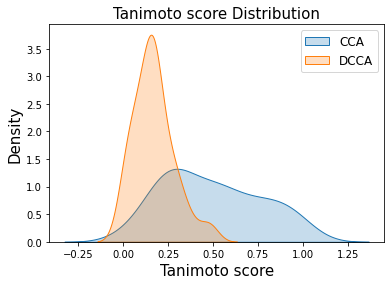

In [26]:
#plot the distribution of the three top tanimotos from the three metrics
dist_list = [val_cca_corr_tanimotos,val_dcca_corr_tanimotos]
for dist in dist_list:
    ax=sns.kdeplot(x=dist,shade=True)
plt.legend(labels=['CCA','DCCA'], loc='upper right', fontsize=12)
plt.xlabel('Tanimoto score', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.title(label='Tanimoto score Distribution', fontsize=15)
plt.show()

#### Draw Random predicted molecule

In [224]:
from rdkit import Chem
from rdkit.Chem import Draw

In [225]:
import random
keys = random.sample(val_cca_corr.keys(),5)
sample_dict = {key: val_cca_corr[key] for key in keys}

C:\Users\lmeli\AppData\Local\Temp/ipykernel_9060/2787882833.py:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  keys = random.sample(val_cca_corr.keys(),5)


In [226]:
for key, values in sample_dict.items():
    print(key,max(values))

20 0.5823927200731371
29 0.6650521488983744
4 0.6495048918267161
12 0.6197480601063927
30 0.6799384702138038


In [196]:
val_df.head(2)

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,z1,z2,cca_z1,cca_z2
11815,CSc1ccc(cc1)C(=O)c2[nH]c(O)nc2C,ZJKNESGOIKRXQY-UHFFFAOYSA-N,ZJKNESGOIKRXQY,spec_id10578,"[10.002183663278936, 8.101198818303725, -25.87...","[30.508310317993164, 2.4317686557769775, 0.0, ...","[2.8967903, -1.528918, -2.38157, 5.095014, 0.1...",Organooxygen compounds,"[0.10335389, 0.058054164, 0.03416656, -0.07301...","[-0.040379975, 0.011812843, 0.11290356, 0.0830...","[0.45538428812733994, -0.8522359091803, -0.061...","[0.5021923494200131, -0.905309487516812, -0.21..."
11541,CCCCCCCCN[C@H](C)[C@@H](O)c1ccc(SC(C)C)cc1,BFCDFTHTSVTWOG-YLJYHZDGSA-N,BFCDFTHTSVTWOG,spec_id10324,"[-11.560261438538404, 21.197388865072792, -5.3...","[0.0, 0.0, 0.0, 51.11786651611328, 0.0, 0.0, 0...","[-0.59031224, -0.8139145, -1.3731441, 4.333156...",Benzene and substituted derivatives,"[0.08559358, 0.06372802, 0.03648443, -0.063771...","[-0.039873503, 0.012518503, 0.121197894, 0.061...","[0.17765060170107805, -0.8833842129168374, 0.2...","[-0.10442078768350732, -1.0131203373119348, -0..."


In [197]:
val_df['smiles'].iloc[0]

'CSc1ccc(cc1)C(=O)c2[nH]c(O)nc2C'

In [227]:
#function to draw structuctures
all_mols = []
scores = []
#os.chdir('../compounds')
for query_index, values in tqdm(sample_dict.items()):
    top_hits = np.sort(values)[::-1][:5]
    tanimotos = []
    #draw the query
    
    query_smile= val_df['smiles'].iloc[query_index]
    query_class = val_df['cf_class'].iloc[query_index]
    query = Chem.MolFromSmiles(query_smile)
    #Draw.MolToFile(query, f"dcca_max_corr_query_{query_index}_{query_class}.png")
    #Draw.MolsToGridImage(query)
    #draw top 5 hits
    subjects = [query,]
    for hit_index, hit in enumerate(top_hits):
        subject_index = values.index(hit)
        subject_smile = train_df['smiles'].iloc[subject_index]
        subject_class = train_df['cf_class'].iloc[subject_index]
        
        subject = Chem.MolFromSmiles(subject_smile)
        subjects.append(subject)
        #Draw.MolToFile(subject, f"dcca_max_corr_query_{query_index}_hit_{hit_index}_{subject_class}.png")
        
        #check tanimotos for the random selections
        tanimotos.append(tanimoto(query_smile,subject_smile))
    scores.append([(query_index,query_class),tanimotos])
    all_mols.append(subjects)
#scores       
#os

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.27it/s]


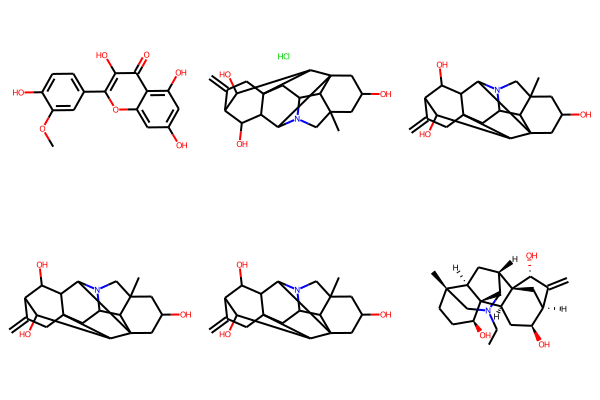

In [233]:
mol = Draw.MolsToGridImage(all_mols[4])
mol

In [90]:
corr = []
for query_index, values in val_dcca_corr.items():
    corr.append(max(values))
    hits = np.sort(values)[::-1][:5]
    subject_id = values.index(hits[0])
#     print(query_index,hits)
#     break

In [54]:
train_df.index[subject_id]

41401

In [67]:
smile1 = val_df['smiles'].iloc[0]
smile2 = train_df['smiles'].iloc[subject_id]#,'smiles']
tanimoto(smile1,smile2)

0.2637

In [68]:
train_df.iloc[subject_id]

smiles        CCC(C)C1C(=O)NC(C(=O)NCC(=O)NC(C(=O)NC2(C(=O)N...
inchi_key                           TXVROFQRFWFJGU-UHFFFAOYSA-N
inchikey14                                       TXVROFQRFWFJGU
spec_id                                              spec_id269
spec2vec      [-0.4372154119527797, -3.586573570831483, -1.3...
ms2ds         [0.0, 11.000090599060059, 8.050064086914062, 0...
mol2vec       [14.788205, -23.74288, -29.3895, 54.319523, -1...
cf_class                                                    NaN
z1            [0.12526077, 0.031255014, 0.1613245, 0.2529315...
z2            [-3.38419, 4.7171087, 0.55749464, -0.54395986,...
Name: 305, dtype: object

In [61]:
val_df.head(1)

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,z1,z2
11815,CSc1ccc(cc1)C(=O)c2[nH]c(O)nc2C,ZJKNESGOIKRXQY-UHFFFAOYSA-N,ZJKNESGOIKRXQY,spec_id10578,"[10.002183663278936, 8.101198818303725, -25.87...","[30.508310317993164, 2.4317686557769775, 0.0, ...","[2.8967903, -1.528918, -2.38157, 5.095014, 0.1...",Organooxygen compounds,"[0.10335389, 0.058054164, 0.03416656, -0.07301...","[-0.040379975, 0.011812843, 0.11290356, 0.0830..."


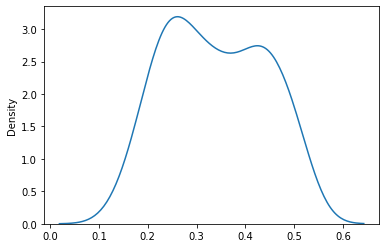

In [91]:
ax=sns.kdeplot(x=corr,shade=False)